---
title: 8.1 门控循环单元（GRU）
date: 2024-5-6 12:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#  
<!--more-->
# 1 门控循环单元（GRU）

- 上一节，我们讨论了如何在循环神经网络中计算梯度，以及矩阵连续乘积可以导致梯度消失或梯度爆炸的问题。下面我们简单思考一下这种梯度异常在实践中的意义：

    - case1：早期观测值对预测所有未来观测值具有非常重要的意义。例如，第一个观测值包含一个校验和，目标是在序列的末尾辨别校验和是否正确。在这种情况下，第一个词元的影响至关重要。我们希望有某些机制能够在一个记忆元里存储重要的早期信息。如果没有这样的机制，我们将不得不给这个观测值指定一个非常大的梯度，因为它会影响所有后续的观测值。

    - case2：一些词元没有相关的观测值。例如，在对网页内容进行情感分析时，可能有一些辅助HTML代码与网页传达的情绪无关。我们希望有一些机制来跳过隐状态表示中的此类词元。

    - case3：序列的各个部分之间存在逻辑中断。例如，书的章节之间可能会有过渡存在。需要一种方法来重置我们的内部状态表示。

- 对于这类问题，可以使用“长短期记忆”（long‐short‐term memory，LSTM）。门控循环单元（gated recurrent unit，GRU）是一个稍微简化的变体，通常能够提供同等的效果，并且计算速度明显更快。

## 1.1 门控隐状态

- GRU与普通rnn的关键区别在于：前者支持隐状态的门控。这意味着模型有专门的机制来确定应该何时更新隐状态，以及应该何时重置隐状态。这些机制是可学习的，并且能够解决了上面列出的问题。例如，如果第一个词元非常重要，模型将学会在第一次观测之后不更新隐状态。同样，模型也可以学会跳过不相关的临时观测。最后，模型还将学会在需要的时候重置隐状态。各类门控如下：

### 1.1.1 重置门（reset gate）和更新门（update gate）

- 我们把它们设计成(0, 1)区间中的向量，这样就可以进行凸组合。重置门允许我们控制“可能还想记住”的过去状态的数量；更新门将允许我们控制新状态中有多少个是旧状态的副本。

- 下图描述了门控循环单元中的重置门和更新门的输入，输入是由当前时间步的输入和前一时间步的隐状态给出。两个门的输出是由使用sigmoid激活函数的两个全连接层给出。

![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/8_moden_rnn/1_GRU/1.png)
![](img/deeplearning/code/pytorch/8_moden_rnn/1_GRU/1.png)

- 假设在时间步t，输入是小批量$ \mathbf{ X } _ { t } \in \mathbb{ R } ^ { n \times d } $（样本数为n，输入个数为d），前一时间步的隐状态是$ \mathbf{ H } _ { t - 1 } \in \mathbb{ R } ^ { n \times h } $（隐藏单元个数为h）。重置门$ \mathbf{ R } _ { t } \in \mathbb{ R } ^ { n \times h } $和更新门$ \mathbf{ Z } _ { t } \in \mathbb{ R } ^ { n \times h } $的计算如下：

$$ \begin{aligned} \mathbf{ R } _ { t } & = \sigma \left( \mathbf{ X } _ { t } \mathbf{ W } _ { x r } + \mathbf{ H } _ { t - 1 } \mathbf{ W } _ { h r } + \mathbf{ b } _ { r } \right) , \\ \mathbf{ Z } _ { t } & = \sigma \left( \mathbf{ X } _ { t } \mathbf{ W } _ { x z } + \mathbf{ H } _ { t - 1 } \mathbf{ W } _ { h z } + \mathbf{ b } _ { z } \right) . \end{aligned} $$

- 在求和过程中会触发广播机制。

### 1.1.2 候选隐藏状态

- 将重置门与常规隐状态更新机制集成，得到在时间步t的候选隐状态（candidate hidden state）$ \tilde { \mathbf{ H } } _ { t } \in \mathbb{ R } ^ { n \times h } $：

$$ \tilde { \mathbf{ H } } _ { t } = \tanh \left( \mathbf{ X } _ { t } \mathbf{ W } _ { x h } + \left( \mathbf{ R } _ { t } \odot \mathbf{ H } _ { t - 1 } \right) \mathbf{ W } _ { h h } + \mathbf{ b } _ { h } \right) . $$

- 其中$ \odot $是Hadamard积（按元素乘积）。使用tanh非线性激活函数来确保候选隐状态中的值保持在区间(−1, 1)中。
- 与原始的隐状态更新机制相比，这种方法中的$ \mathbf{ R } _ { t } $和$ \mathbf{ H } _ { t - 1 } $的元素相乘可以减少以往状态的影响。每当重置门$ \mathbf{ R } _ { t } $中的项接近1时，我们恢复一个普通的循环神经网络。对于重置门$ \mathbf{ R } _ { t } $中所有接近0的项，候选隐状态是以$ \mathbf{ X } _ { t } $为输入的多层感知机的输出。因此，任何预先存在的隐状态都会被重置为默认值。应用重置门之后的计算流程:

![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/8_moden_rnn/1_GRU/2.png)
![](img/deeplearning/code/pytorch/8_moden_rnn/1_GRU/2.png)

### 1.1.3 隐状态

- 上述计算了候选隐状态，我们仍然需要结合更新门$ \mathbf{ Z } _ { t } $的效果。这一步确定新的隐状态$ \mathbf{ H } _ { t } \in \mathbb{ R } ^ { n \times h } $在多大程度上来自旧的状态$ \mathbf{ H } _ { t - 1 } $和在多大程度上来自新的候选状态$ \tilde { \mathbf{ H } } _ { t } $。更新门仅需在$ \mathbf{ H } _ { t - 1 } $和$ \tilde { \mathbf{ H } } _ { t } $之间进行按元素的凸组合就可以实现这个目标：

$$ \mathbf{ H } _ { t } = \mathbf{ Z } _ { t } \odot \mathbf{ H } _ { t - 1 } + ( 1 - \mathbf{ Z } _ { t } ) \odot \tilde { \mathbf{ H } } _ { t } . $$

- 当更新门$ \mathbf{ Z } _ { t } $接近1时，模型就倾向只保留旧状态，来自$ \matnbf{ X } _ { t } $的信息将被忽略，从而有效地跳过了依赖链条中的时间步t。
- 当更新门$ \mathbf{ Z } _ { t } $接近0时，新的隐状态$ \mathbf{ H } _ { t } $接近候选隐状态$ \tilde { \mathbf{ H } } _ { t } $。这种情况会重置隐状态，以便在新的时间步中丢弃旧的状态。
- 这些设计可以帮助我们处理循环神经网络中的梯度消失问题，并更好地捕获时间步距离很长的序列的依赖关系。

- 更新门起作用后的计算流：

![](../../../../../../themes/yilia/source/img/deeplearning/code/pytorch/8_moden_rnn/1_GRU/3.png)
![](img/deeplearning/code/pytorch/8_moden_rnn/1_GRU/3.png)

- 门控循环单元具有以下两个显著特征：
    
    - 重置门有助于捕获序列中的短期依赖关系
    - 更新门有助于捕获序列中的长期依赖关系

## 1.2 从零开始实现

- 读取数据集

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# 读取数据集
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 1.2.1 初始化模型参数
- 从标准差为0.01的高斯分布中提取权重，并将偏置项设为0，超参数num_hiddens定义隐藏单元的数量，实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。

In [2]:
# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))
    
    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐藏状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 1.2.2 定义模型
- 定义隐状态的初始化函数init_gru_state。此函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零。

In [3]:
# 初始化隐状态
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

- 定义门控循环单元模型，模型的架构与基本的循环神经网络单元是相同的，只是权重更新公式更为复杂。

In [4]:
# 定义门控循环单元模型
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(torch.matmul(X, W_xz) + torch.matmul(H, W_hz) + b_z)
        R = torch.sigmoid(torch.matmul(X, W_xr) + torch.matmul(H, W_hr) + b_r)
        H_tilda = torch.tanh(torch.matmul(X, W_xh) + R * torch.matmul(H, W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### 1.2.3 训练与预测
- 训练结束后，我们分别打印输出训练集的困惑度，以及前缀“time traveler”和“traveler”的预测序列上的困惑度。

perplexity 1.1, 23766.8 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
travellerithe thing seei think so murmured the provincial m


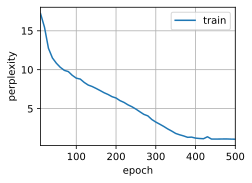

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

![](img/deeplearning/code/pytorch/8_moden_rnn/1_GRU_files/1_GRU_9_1.svg)

## 1.3 简洁实现
- 这段代码的运行速度要快得多，因为它使用的是编译好的运算符而不是Python来处理之前阐述的许多细节。

perplexity 1.0, 20716.4 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


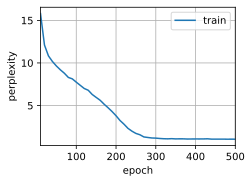

In [6]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

![](img/deeplearning/code/pytorch/8_moden_rnn/1_GRU_files/1_GRU_11_1.svg)